# import/mounts

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [38]:
# Previously defined function
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [39]:
# Previously defined function
def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

In [40]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [41]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [42]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
data = "/content/drive/My Drive/Coursework/adult.csv"

# Load in data
df = pd.read_csv(data)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [44]:
df.info

<bound method DataFrame.info of        age     workclass  fnlwgt     education  educational-num  \
0       25       Private  226802          11th                7   
1       38       Private   89814       HS-grad                9   
2       28     Local-gov  336951    Assoc-acdm               12   
3       44       Private  160323  Some-college               10   
4       18             ?  103497  Some-college               10   
...    ...           ...     ...           ...              ...   
48837   27       Private  257302    Assoc-acdm               12   
48838   40       Private  154374       HS-grad                9   
48839   58       Private  151910       HS-grad                9   
48840   22       Private  201490       HS-grad                9   
48841   52  Self-emp-inc  287927       HS-grad                9   

           marital-status         occupation relationship   race  gender  \
0           Never-married  Machine-op-inspct    Own-child  Black    Male   
1      Marr

# Clean the data

In [45]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

Duplicates found, drop them

In [46]:
# Drop duplicates
df = df.drop_duplicates()
# Obtain the sum of duplicated to confirm all have been dropped
df.duplicated().sum()

0

In [47]:
df = df.drop(columns = ['fnlwgt'])

In [48]:
df.value_counts('educational-num')

educational-num
9     15770
10    10863
13     8013
14     2656
11     2060
7      1812
12     1601
6      1389
4       954
15      834
5       756
8       655
16      594
3       507
2       245
1        81
dtype: int64

In [49]:
df.value_counts('native-country')

native-country
United-States                 43792
Mexico                          943
?                               856
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

In [50]:
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [51]:
df.info

<bound method DataFrame.info of        age     workclass     education  educational-num      marital-status  \
0       25       Private          11th                7       Never-married   
1       38       Private       HS-grad                9  Married-civ-spouse   
2       28     Local-gov    Assoc-acdm               12  Married-civ-spouse   
3       44       Private  Some-college               10  Married-civ-spouse   
4       18             ?  Some-college               10       Never-married   
...    ...           ...           ...              ...                 ...   
48837   27       Private    Assoc-acdm               12  Married-civ-spouse   
48838   40       Private       HS-grad                9  Married-civ-spouse   
48839   58       Private       HS-grad                9             Widowed   
48840   22       Private       HS-grad                9       Never-married   
48841   52  Self-emp-inc       HS-grad                9  Married-civ-spouse   

              occup

### Replace the target for later modeling

In [52]:
df['income'] = df['income'].replace({'<=50K':0})

In [53]:
df['income'] = df['income'].replace({'>50K':1})

In [54]:
df['income'].value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        1
3        1
4        0
        ..
48837    0
48838    1
48839    0
48840    0
48841    1
Name: income, Length: 48790, dtype: int64>

In [55]:
df['income'] = df['income'].astype(int)

In [56]:
# Find correlations
corr = df.corr()
corr.round(2)

<ipython-input-56-5b5da7b4f2fd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,age,educational-num,capital-gain,capital-loss,hours-per-week,income
age,1.00,0.03,0.08,0.06,0.07,0.23
educational-num,0.03,1.00,0.13,0.08,0.14,0.33
capital-gain,0.08,0.13,1.00,-0.03,0.08,0.22
capital-loss,0.06,0.08,-0.03,1.00,0.05,0.15
hours-per-week,0.07,0.14,0.08,0.05,1.00,0.23
income,0.23,0.33,0.22,0.15,0.23,1.00


# Correlation map / Visuals

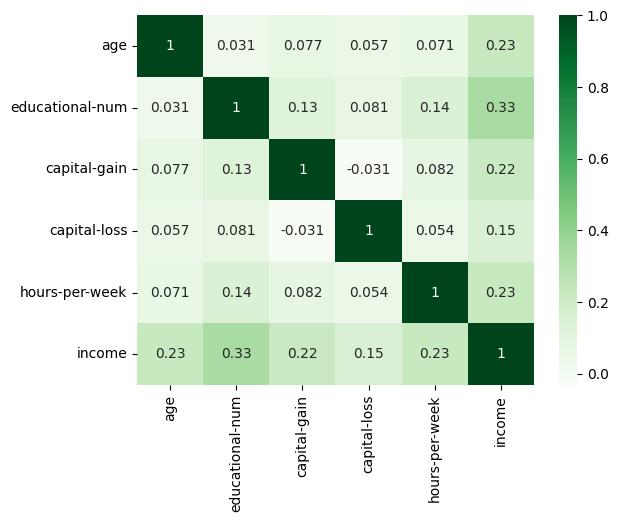

In [57]:
# Make a heatmap using the correlations from above
sns.heatmap(corr, cmap = 'Greens', annot = True);

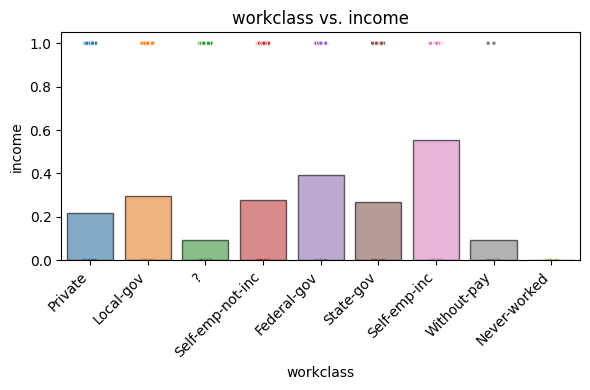

In [58]:
plot_categorical_vs_target(df, 'workclass', 'income');

Here we can take note that federal employees and those who are self employed seem to be faring the best

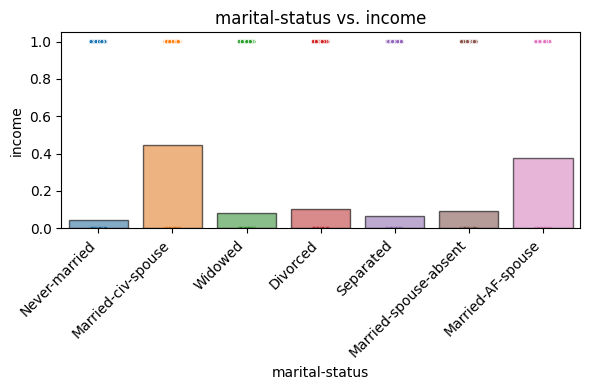

In [59]:
plot_categorical_vs_target(df, 'marital-status', 'income');

Unsurprisingly those who are married tend to be more fiscally secure on average

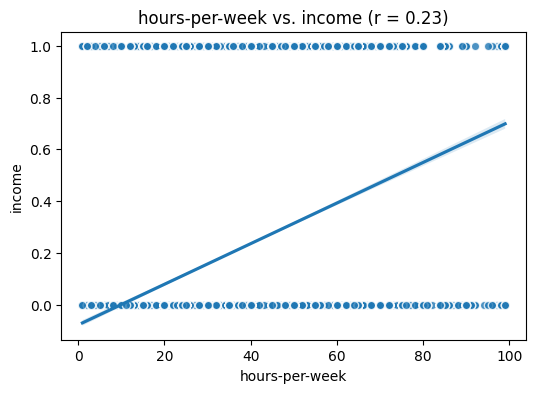

In [60]:
plot_numeric_vs_target(df, 'hours-per-week', 'income');

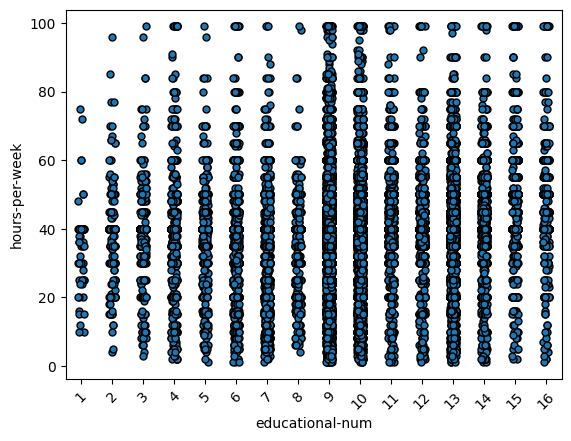

In [61]:
# Make a strip plot for the highest correlation value
ax = sns.stripplot(data=df, x='educational-num', y='hours-per-week', edgecolor='black', linewidth=1)
ax.tick_params(axis='x', rotation=45)

The visualization shown above demonstrates a slight decrease in higher hours worked with further education compared to those with 9-10 years of education averaging the most hours worked

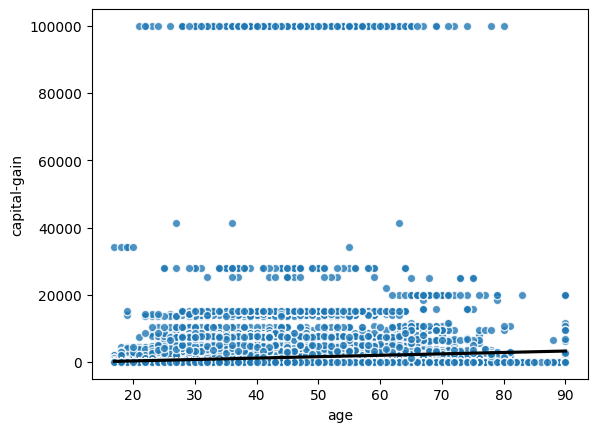

In [62]:
# Look to confirm a trend line between age and capital gain
line_kws = dict(color='black')
scatter_kws = dict(edgecolor='white')
ax = sns.regplot(data=df, x='age', y="capital-gain",
                 line_kws=line_kws, scatter_kws=scatter_kws);

As expected from above we see a weak positive trend between progressing in age and capital gains

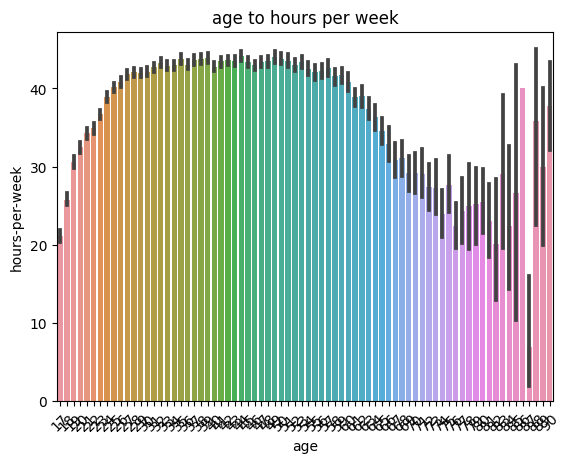

In [87]:
ax = sns.barplot(data=df, x='age', y='hours-per-week',  )
ax.set_title('age to hours per week')
ax.set_ylabel('hours-per-week')
ax.set_xlabel('age')
ax.tick_params(axis='x', rotation=45)

Here we see that peak hours start at about age 30 and don't begin to taper off until roughly 60 when people begin to retire

<ipython-input-64-d7a0dcd2dc70>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=df, x='educational-num', y='capital-loss',palette="deep")


Text(0.5, 0, 'education')

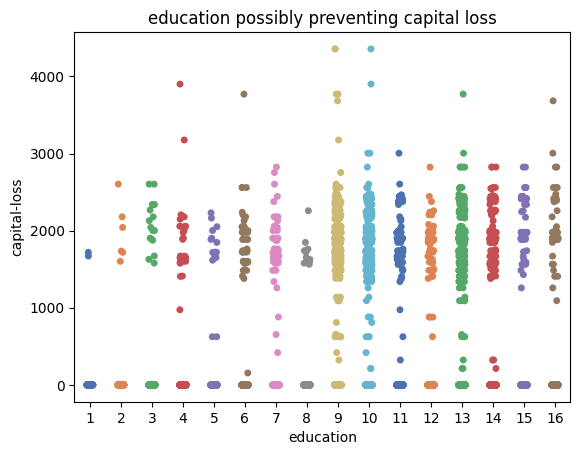

In [64]:
ax = sns.stripplot(data=df, x='educational-num', y='capital-loss',palette="deep")
ax.set_title('education possibly preventing capital loss')
ax.set_ylabel('capital-loss')
ax.set_xlabel('education')

Here we see the majority of capital loss cases happen to those with 9-12 years of education

#Begin modeling

Train/Test split

In [65]:
X = df.drop(columns = ['income'])
y=df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [66]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [67]:
# Prepare Categorical pipeline
cat_cols = X_train.select_dtypes('object').columns
print("Catergoric Columns:", cat_cols)
# Get the unique categories for each categorical column
# Impute Most common
impute_missing = SimpleImputer(strategy='most_frequent',fill_value='MISSING')
    # We will be using most frequent over constant for better results
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # We will be using one hot for the unordered features
cat_pipe = make_pipeline(impute_missing, cat_encoder)
# Making a categorical tuple for ColumnTransformer
cat_tuple = ('categorical', cat_pipe, cat_cols)

Catergoric Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')


In [68]:
col_transformer = ColumnTransformer([num_tuple , cat_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [69]:
# Transform the training data
X_train_tf = col_transformer.transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# View the processed training data
X_train_tf.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
38093,3.166708,0.355778,-0.145433,-0.217031,-2.608202,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43391,-0.634069,1.522115,-0.145433,-0.217031,0.766978,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3064,-0.780252,-0.421779,0.264526,-0.217031,0.365171,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45606,-1.364987,-0.033000,-0.145433,-0.217031,-2.045672,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2116,0.023758,-0.421779,-0.145433,-0.217031,-0.036636,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Default model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27841
           1       0.98      0.91      0.95      8751

    accuracy                           0.97     36592
   macro avg       0.98      0.95      0.96     36592
weighted avg       0.97      0.97      0.97     36592



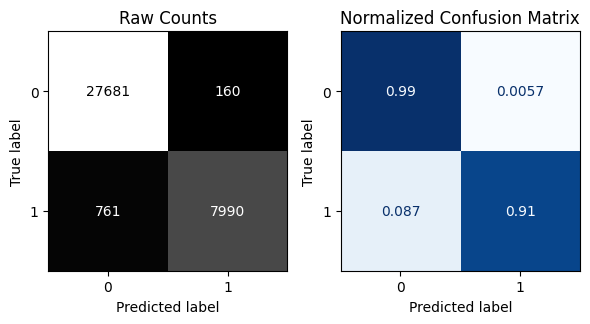


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9268
           1       0.64      0.61      0.62      2930

    accuracy                           0.82     12198
   macro avg       0.76      0.75      0.75     12198
weighted avg       0.82      0.82      0.82     12198



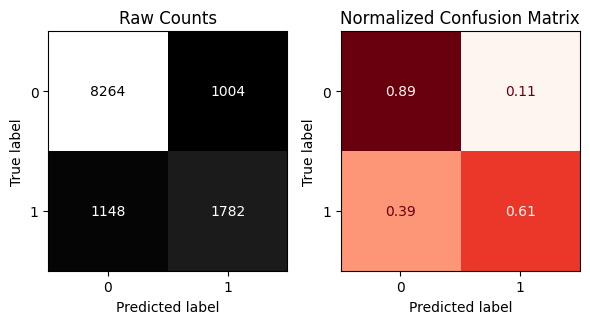

In [70]:
#Instantiate a default model for a baseline to refer back to
model = DecisionTreeClassifier(random_state = 42)

model.fit(X_train_tf, y_train)
# Use custom function to predict and evaluate
evaluate_classification(model, X_train_tf, y_train, X_test_tf, y_test)

We see a sharp decrease in the R2 from the training to test data

# Model 2

In [71]:
#Instantiate a second model for tuning
tree = DecisionTreeClassifier(random_state = 42)

In [72]:
# Create the Column Transformer and instantiate pipeline
preprocessor = ColumnTransformer([num_tuple],
                                     verbose_feature_names_out=False)

dec_tree_pipe = make_pipeline(preprocessor, tree)

In [73]:
# fit model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     27841
           1       0.89      0.58      0.71      8751

    accuracy                           0.88     36592
   macro avg       0.89      0.78      0.82     36592
weighted avg       0.88      0.88      0.87     36592



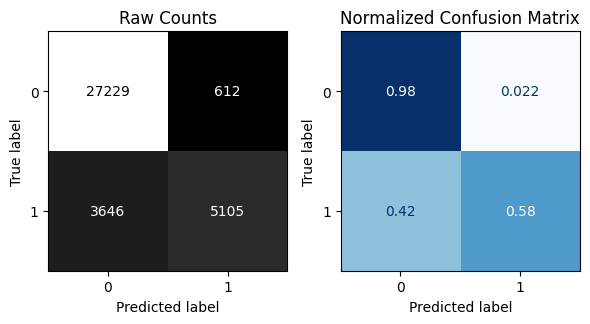


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      9268
           1       0.69      0.45      0.55      2930

    accuracy                           0.82     12198
   macro avg       0.76      0.69      0.72     12198
weighted avg       0.81      0.82      0.80     12198



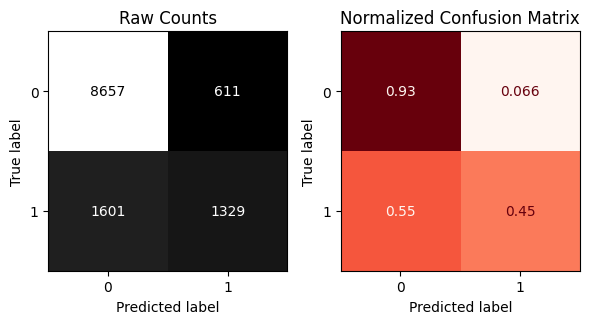

In [74]:
# Make predictions and evalute with custom function with no params set
evaluate_classification(dec_tree_pipe, X_train, y_train, X_test, y_test)

# GridSearch CV

In [75]:
# Looking at options for tuning this model
dec_tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
          'hours-per-week'],
         dtype='object'))],
                     verbose_feature_names_out=False)),
  ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
      

In [76]:
param_grid = {'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
              'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'decisiontreeclassifier__min_samples_split': [2, 3, 4]}

In [77]:
grid_search = GridSearchCV(dec_tree_pipe, param_grid, n_jobs = -1, verbose = 1)

In [78]:
# Fit the Gridsearch on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10,
                                                               None],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5, 6,
                                                                      7, 8, 9,
                                                                      10],
                         'decisiontreeclassifier__min_samples_split': [2, 3,
                                                                       4]},
             verbose=1)

In [79]:
# Obtain the best params
grid_search.best_params_

{'decisiontreeclassifier__max_depth': 10,
 'decisiontreeclassifier__min_samples_leaf': 9,
 'decisiontreeclassifier__min_samples_split': 2}

In [80]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Decision Tree with best params

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     27841
           1       0.77      0.49      0.60      8751

    accuracy                           0.84     36592
   macro avg       0.81      0.72      0.75     36592
weighted avg       0.83      0.84      0.83     36592



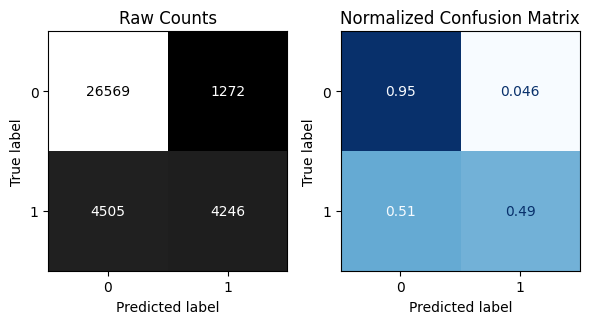


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      9268
           1       0.73      0.47      0.57      2930

    accuracy                           0.83     12198
   macro avg       0.79      0.71      0.73     12198
weighted avg       0.82      0.83      0.82     12198



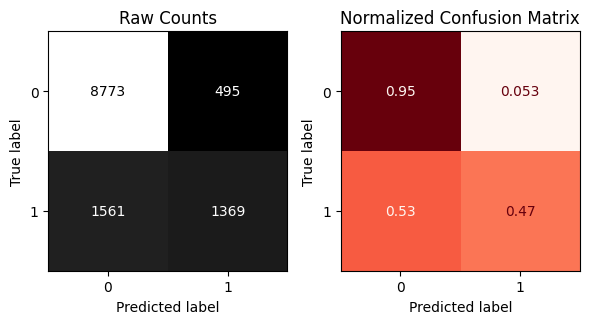

In [81]:
# Predict and Evaluate with custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

# PCA

In [82]:
# Encode our target
le = LabelEncoder()
y = le.fit_transform(df['income'])

In [83]:
# Create a transformer pipeline
transformer = make_pipeline(StandardScaler(), PCA(n_components=.95))
# Put the PCA Pipeline in Another Pipeline with a Logistic Regression
knn_pipe_pca = make_pipeline(col_transformer,PCA(n_components=.95), KNeighborsClassifier())
knn_pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_va...',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [84]:
# make and fit a pipe
knn_pipe = make_pipeline(col_transformer, KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     27841
           1       0.78      0.70      0.74      8751

    accuracy                           0.88     36592
   macro avg       0.84      0.82      0.83     36592
weighted avg       0.88      0.88      0.88     36592



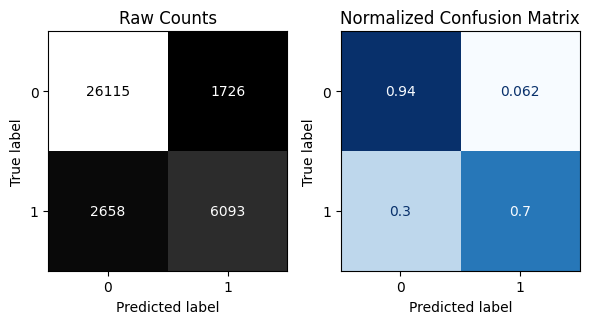


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      9268
           1       0.68      0.59      0.63      2930

    accuracy                           0.83     12198
   macro avg       0.78      0.75      0.76     12198
weighted avg       0.83      0.83      0.83     12198



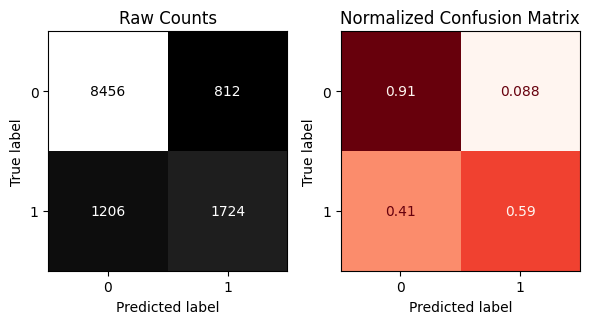

CPU times: user 20 s, sys: 592 ms, total: 20.6 s
Wall time: 13.5 s


In [85]:
%%time
evaluate_classification(knn_pipe_pca, X_train, y_train, X_test, y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     27841
           1       0.78      0.70      0.74      8751

    accuracy                           0.88     36592
   macro avg       0.84      0.82      0.83     36592
weighted avg       0.88      0.88      0.88     36592



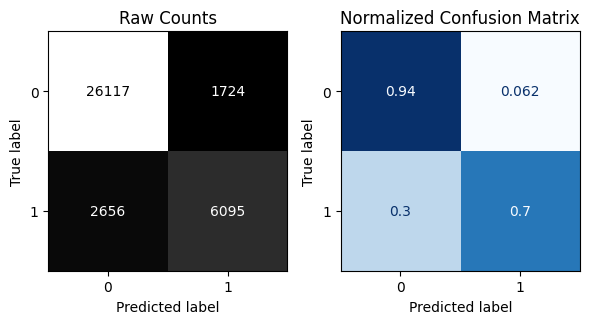


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      9268
           1       0.68      0.59      0.63      2930

    accuracy                           0.84     12198
   macro avg       0.78      0.75      0.76     12198
weighted avg       0.83      0.84      0.83     12198



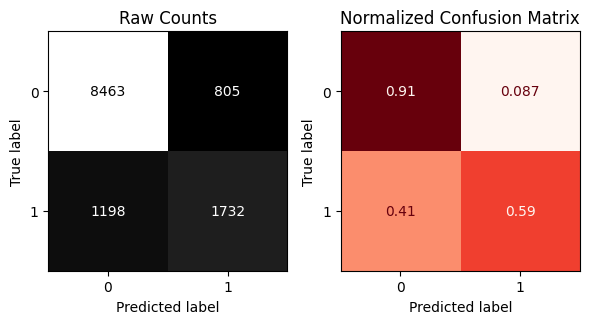

CPU times: user 32.9 s, sys: 361 ms, total: 33.3 s
Wall time: 21.5 s


In [86]:
%%time
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

For our production model we would like to prevent as many false positives as possible so we can prioritize finding those with an annual income higher than 50k. For this reason we would want to use the Best parameter Decision tree model.